In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from cl.eval import EvalReader as EPPS
import seaborn as sns
import numpy as np


In [18]:
def print1(*arg, **karg):
    pass

def common_parse(name, add):
    if name.find("pertask")>=0:
        _, tid, fold = name.split("_")
        name = "{} on fold {}".format(tid, fold)
    return "Result of Task {} {}:".format(name, add)
def listdct_to_dct(lst, kname, vname):
    ret = {}
    for d in lst:
        ret[tuple(d[kname])] = d[vname]
    return ret
def parse_pairwise_ic(name, measure):
    tname = common_parse(name, "Pairwise Inconsistency")
    print(tname)
    pairwise = listdct_to_dct(measure["inconsist_pairwise"], kname="compare", vname="consistency")
    idx = measure["index"]
    l = len(idx)
    _idx_name = ["Model {}".format(i) for i in idx]
    _df = pd.DataFrame(index = _idx_name[:-1], columns = _idx_name[1:]).fillna("")
    for i in range(l):
        for j in range(i+1, l):
            _df.loc[_idx_name[i], _idx_name[j]] = pairwise[(idx[i],idx[j])]
    #_df.style.set_caption(tname)
    print(_df)
    return _df

def parse_acc(name, measure):
    print(common_parse(name, "Accuracy Per Step"))
    for i in range(len(measure["index"])):
        print(measure["acc_list"][i], end="\t")
    print("avg acc", np.mean(measure["acc_list"]))
    return measure["acc_list"][-1]#np.mean(measure["acc_list"])

def parse_total(name, measure):
    print(common_parse(name, "Inconsistency Together"))
    print(measure["inconsist_tot"])
    return measure["inconsist_tot"]

In [19]:
def read_result(evaluator, bname):
    global rec
    e = evaluator
    print("="*50)
    rec[bname] = []
    for name in e.names[:-3]:
        parse_pairwise_ic(name, e._measure_pairwise(name))
        print()
        acc = parse_acc(name,e._measure_acc(name))
        print()
        tot = parse_total(name, e._measure([name]))
        true_name = "_".join(name.split("_")[-2:])
        rec[bname].append((true_name,tot,acc))
        print(tot)
def draw_pic(picname):
    names = ["vanilla","lwf", "ewc"]#,"vanilla_scratch","lwf_scratch", "ewc_scratch"]
    tasks = []
    vals = []
    comps = []
    accs = []
    print(rec)
    for name in names:
        for v in rec[name]:
            task, val, acc = v
            comps.append(name)
            tasks.append(task)
            accs.append(acc)
            vals.append(val)
    plt.figure(figsize=(10,10))
    df = pd.DataFrame({"Task":tasks, "Method":comps, "Inconsistency":vals, "Acc":accs})
    pd.melt(df, id_vars=['Task'], value_vars=['Inconsistency'])
    sns.barplot(x = 'Task', y = 'Inconsistency', data = df, hue="Method")
    plt.ylabel('Inconsistency')
    plt.title('Inconsistency over different baselins')
    plt.savefig("Inconsistency_{}.png".format(picname))
    plt.show()
    plt.figure(figsize=(10,10))
    df = pd.DataFrame({"Task":tasks, "Method":comps, "Inconsistency":vals, "Acc":accs})
    pd.melt(df, id_vars=['Task'], value_vars=['Acc'])
    sns.barplot(x = 'Task', y = 'Acc', data = df, hue="Method")
    plt.ylabel('Acc')
    plt.title('Acc over different baselins')
    plt.savefig("Acc_{}.png".format(picname))
    plt.show()

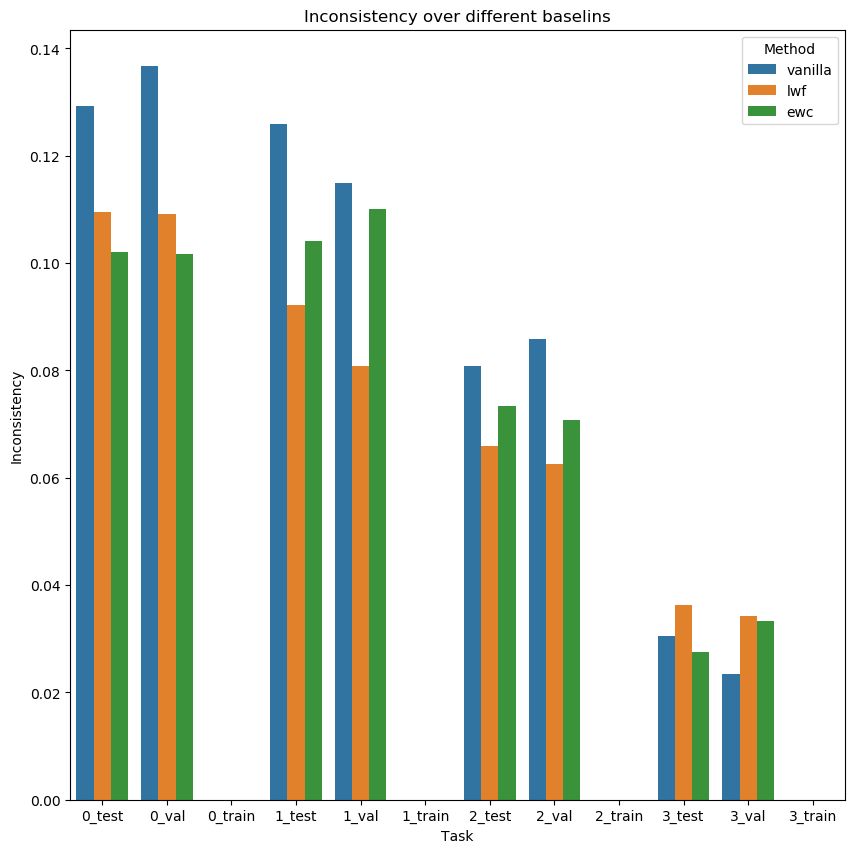

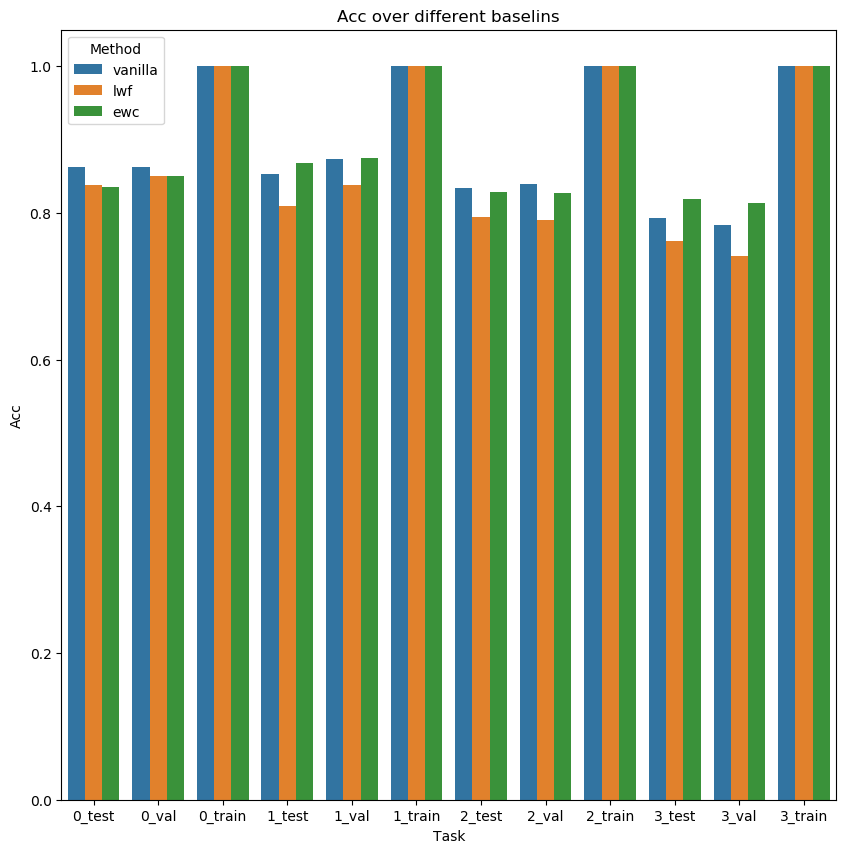

FileNotFoundError: [Errno 2] No such file or directory: 'results/cifar10_ResNet18_1.0e-02_#vanilla_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed0_measure.json'

In [20]:
epps = EPPS()
for i in range(1):
    rec = {}
    #epps.load("results/cifar10_5_domain_inc")
    epps.load("results/cifar10_ResNet18_1.0e-02_#vanilla_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "vanilla")
    epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "lwf")
    epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps,"ewc")
    """epps.load("results/cifar10_ResNet18_1.0e-02_#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "vanilla_scratch")
    epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "lwf_scratch")
    epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps,"ewc_scratch")"""
    draw_pic("Domain_Inc_seed_{}".format(i))
for i in range(1):
    rec = {}
    #epps.load("results/cifar10_5_domain_inc")
    epps.load("results/cifar10_ResNet18_1.0e-02_#vanilla_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "vanilla")
    epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "lwf")
    epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps,"ewc")
    epps.load("results/cifar10_ResNet18_1.0e-02_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "vanilla_scratch")
    epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps, "lwf_scratch")
    epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
    read_result(epps,"ewc_scratch")
    draw_pic("Data_Inc_seed_{}".format(i))    

In [19]:
print(epps.names)
print(epps.hist_version["pertask_0_test"][:10,:10])

['perslice__Task_0_test', 'perslice__Task_0_val', 'perslice__Task_0_train', 'perslice__Task_1_test', 'perslice__Task_1_val', 'perslice__Task_1_train', 'perslice__Task_2_test', 'perslice__Task_2_val', 'perslice__Task_2_train', 'perslice__Task_3_test', 'perslice__Task_3_val', 'perslice__Task_3_train', 'perslice__Task_4_test', 'perslice__Task_4_val', 'perslice__Task_4_train']


KeyError: 'pertask_0_test is not a file in the archive'